# **Data Cleaning**

We first import the necessary packages and read in the datasets.

Run the cell to display the invoice_data dataframe to check whether the data has been loaded successfully.

In [ ]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Read the datasets
client_data = pd.read_csv("client.csv")
invoice_data = pd.read_csv("invoice.csv")

# [testing] displaying invoice_data
invoice_data

print(invoice_data.dtypes)

id                       object
date                     object
tarif_type                int64
counter_number          float64
counter_statue            int64
counter_code              int64
reading_remarque          int64
consommation_level_4      int64
old_index                 int64
new_index                 int64
months_number             int64
counter_type             object
counter_coefficient       int64
consommation_level_1      int64
consommation_level_2      int64
consommation_level_3      int64
dtype: object


We then separate the invoices into gas_invoice (for gas consumption) and elec_invoice (for electricity consumption).


Run the cell to display the gas_invoice dataframe to check whether the data has been loaded successfully.

In [ ]:
gas_invoice = invoice_data[invoice_data['counter_type'] == 'GAZ']
elec_invoice = invoice_data[invoice_data['counter_type'] == 'ELEC']

# [testing] displaying gas_invoice
gas_invoice

,id,date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_4,old_index,new_index,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3
124,train_Client_10000,5/12/2015,40,205147.0,0,5,9,0,4355,5048,4,GAZ,1,693,0,0
127,train_Client_10000,18/1/2016,40,205147.0,0,5,8,0,5077,5077,2,GAZ,1,0,0,0
129,train_Client_10000,5/9/2017,40,205147.0,0,5,9,0,5138,5518,4,GAZ,1,380,0,0
134,train_Client_10000,14/5/2012,40,205147.0,0,5,9,0,1136,1678,4,GAZ,1,542,0,0
136,train_Client_10000,13/5/2014,40,205147.0,0,5,9,0,3239,3839,4,GAZ,1,600,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500590,train_Client_128436,26/1/2015,40,2503538.0,0,5,9,0,8983,9097,4,GAZ,1,114,0,0
500591,train_Client_128436,15/5/2017,40,2503538.0,0,5,6,0,9560,9650,4,GAZ,1,90,0,0
500596,train_Client_128436,25/1/2016,40,2503538.0,0,5,6,0,9258,9329,4,GAZ,1,71,0,0
500598,train_Client_128436,16/5/2016,40,2503538.0,0,5,6,0,9329,9443,4,GAZ,1,114,0,0


In the next two cells, we define the functions to transform and merge the two dataframes client_data and invoice_data together.

In [ ]:
def level_check(row):
    if row['consommation_level_4']:
        return 4
    elif row['consommation_level_3']:
        return 3
    elif row['consommation_level_2']:
        return 2
    elif row['consommation_level_1']:
        return 1
    else:
        return 0

In [ ]:
def invoice_to_client(invoice_under, client_under): # input invoice_csv and client_csv, output combined client_csv, keep the dimension (col)

    # make copies of invoice_under, client_under
    invoice_under = invoice_under.copy()
    client_under = client_under.copy()

    # reformatting 'date'
    invoice_under['date'] = pd.to_datetime(invoice_under['date'], format='%d/%m/%Y')

    invoice_under_add = invoice_under.copy()

    # combine data from 'old_index' and 'new_index' to make a new variable called 'index_diff'
    invoice_under_add['index_diff'] = invoice_under_add['new_index'] - invoice_under_add['old_index']

    # combine data from all consommation levels to make a new variable called 'consommation_sum'
    invoice_under_add['consommation_sum'] = invoice_under_add['consommation_level_1'] + invoice_under_add['consommation_level_2'] + invoice_under_add['consommation_level_3'] + invoice_under_add['consommation_level_4']

    # filter data according to the two types of consumption: for electricity and for gas
    elec_under = invoice_under_add[invoice_under['counter_type'] == 'ELEC']
    gas_under = invoice_under_add[invoice_under['counter_type'] == 'GAZ']
    client_dict_elec = {}
    client_dict_gas = {}
    # put all invoices from the same client into the same key value in a dictionary for easier references
    for i in client_under['id']:
        client_dict_elec[i] = elec_under[elec_under['id'] == i]
        client_dict_gas[i] = gas_under[gas_under['id'] == i]

    # for GAZ: find the time range (in years) between the earliest and latest invoices for each client
    range_year_client_gas = {}
    for i in client_under['id']:
        range_year_client_gas[i] = (client_dict_gas[i]['date'].max().year - client_dict_gas[i]['date'].min().year)

    # for ELEC: find the time range between the earliest and latest invoices for each client
    range_year_client_elec = {}
    for i in client_under['id']:
      range_year_client_elec[i] = (client_dict_elec[i]['date'].max().year - client_dict_elec[i]['date'].min().year)

    # for ELEC: find the mean and standard deviation of the number of invoices per year for each client
    mean_year_client_elec = {}
    sd_year_client_elec = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_elec[i]['date']:
            if j.year in d:
                d[j.year] += 1
            else:
                d[j.year] = 1
        mean_year_client_elec[i] = sum(d.values())
        sd_year_client_elec[i] = np.std(list(d.values()))

    # for GAZ: find the mean and standard deviation of the number of invoices per year for each client
    mean_year_client_gas = {}
    sd_year_client_gas = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_gas[i]['date']:
            if j.year in d:
                d[j.year] += 1
            else:
                d[j.year] = 1
        mean_year_client_gas[i] = sum(d.values())
        sd_year_client_gas[i] = np.std(list(d.values()))

    # create a new column called 'consommation_reach' which indicates the highest level of consumption level for each invoice
    invoice_under_add['consommation_reach'] = invoice_under_add.apply(level_check, axis = 1)

    # for GAZ: find the number of unique counters
    unique_counter_num_gas = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_gas[i]['counter_number']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_counter_num_gas[i] = len(d.keys())

    # for ELEC: find the number of unique counters
    unique_counter_num_elec = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_elec[i]['counter_number']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_counter_num_elec[i] = len(d.keys())

    # for ELEC: find the proportion of counter statuses
    prop_counter_statue_elec = {}
    for i in client_under['id']:
        d = [0] * 6
        for j in client_dict_elec[i]['counter_statue']: # if no invoice then all 0
            d[j] += 1
        d = np.array(d)
        d = d / np.sum(d)
        prop_counter_statue_elec[i] = d

    # for GAZ: find the proportion of counter statuses
    prop_counter_statue_gas = {}
    for i in client_under['id']:
        d = [0] * 6
        for j in client_dict_gas[i]['counter_statue']:
            d[j] += 1
        d = np.array(d)
        d = d / np.sum(d)
        prop_counter_statue_gas[i] = d

    # for ELEC: find median and range of reading remarks
    median_reading_elec = {}
    range_reading_elec = {}
    for i in client_under['id']:
        median = np.median(client_dict_elec[i]['reading_remarque'])
        rang = client_dict_elec[i]['reading_remarque'].max() - client_dict_elec[i]['reading_remarque'].min()
        if len(client_dict_gas[i]['reading_remarque']) == 0: # if no invoice then median and range = 0
            median = 0
            rang = 0
        median_reading_elec[i] = median
        range_reading_elec[i] = rang

    # for GAZ: find median and range of reading remarks
    median_reading_gas = {}
    range_reading_gas = {}
    for i in client_under['id']:
        median = np.median(client_dict_gas[i]['reading_remarque'])
        rang = client_dict_gas[i]['reading_remarque'].max() - client_dict_gas[i]['reading_remarque'].min()
        if len(client_dict_gas[i]['reading_remarque']) == 0: # if no invoice then median and range = 0
            median = 0
            rang = 0
        median_reading_gas[i] = median
        range_reading_gas[i] = rang

    # for ELEC: obtain the number of unique tarif types
    unique_tarif_type_elec = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_elec[i]['tarif_type']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_tarif_type_elec[i] = len(d.keys())

    # for GAZ: obtain the number of unique tarif types
    unique_tarif_type_gas = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_gas[i]['tarif_type']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_tarif_type_gas[i] = len(d.keys())

    # for ELEC: obtain the number of unique counter codes
    unique_counter_code_elec = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_elec[i]['counter_code']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_counter_code_elec[i] = len(d.keys())

    # for GAZ: obtain the number of unique counter codes
    unique_counter_code_gas = {}
    for i in client_under['id']:
        d = {}
        for j in client_dict_gas[i]['counter_code']:
            if j in d:
                d[j] += 1
            else:
                d[j] = 1
        unique_counter_code_gas[i] = len(d.keys())

    # indicate whether each invoice's counter_coefficient contains '1'
    counter_coeff_have1 = {}
    for i in client_under['id']:
        if 1 in list(invoice_under[invoice_under['id'] == i]['counter_coefficient']):
            counter_coeff_have1[i] = 1
        else:
            counter_coeff_have1[i] = 0

    # calculate the proportion of occurrences of different levels of consumption
    consommation_lv = {}
    for i in client_under['id']:
        d = [0] * 5
        for j in invoice_under_add[invoice_under_add['id'] == i]['consommation_reach']:
            d[j] += 1
        d = np.array(d)
        d = d / np.sum(d)
        consommation_lv[i] = d

    # for ELEC: find the mean and standard deviation of the total consumption for each invoice
    mean_consommation_sum_elec = {}
    sd_consommation_sum_elec = {}
    for i in client_under['id']:
        mean_consommation_sum_elec[i] = np.mean(client_dict_elec[i]['consommation_sum'])
        sd_consommation_sum_elec[i] = np.std(client_dict_elec[i]['consommation_sum'])
        if len(client_dict_elec[i]['consommation_sum']) == 0:
            mean_consommation_sum_elec[i] = 0
            sd_consommation_sum_elec[i] = 0

    # for GAZ: find the mean and standard deviation of the total consumption for each invoice
    mean_consommation_sum_gas = {}
    sd_consommation_sum_gas = {}
    for i in client_under['id']:
        mean_consommation_sum_gas[i] = np.mean(client_dict_gas[i]['consommation_sum'])
        sd_consommation_sum_gas[i] = np.std(client_dict_gas[i]['consommation_sum'])
        if len(client_dict_gas[i]['consommation_sum']) == 0:
            mean_consommation_sum_gas[i] = 0
            sd_consommation_sum_gas[i] = 0

    # for GAZ: calculates the mean and standard deviation of 'index_diff' for each client
    mean_oldVSnew_gas = {}
    sd_oldVSnew_gas = {}
    for i in client_under['id']:
        mean_oldVSnew_gas[i] = np.mean(client_dict_gas[i]['index_diff'])
        sd_oldVSnew_gas[i] = np.std(client_dict_gas[i]['index_diff'])
        if len(client_dict_gas[i]['index_diff']) == 0:
            mean_oldVSnew_gas[i] = 0
            sd_oldVSnew_gas[i] = 0

    # for ELEC: calculates the mean and standard deviation of 'index_diff' for each client
    mean_oldVSnew_elec = {}
    sd_oldVSnew_elec = {}
    for i in client_under['id']:
        mean_oldVSnew_elec[i] = np.mean(client_dict_elec[i]['index_diff'])
        sd_oldVSnew_elec[i] = np.std(client_dict_elec[i]['index_diff'])
        if len(client_dict_elec[i]['index_diff']) == 0:
            mean_consommation_sum_elec[i] = 0
            sd_consommation_sum_elec[i] = 0

    # find total number of invoices for each client
    num_gas_invoice = {}
    for i in client_under['id']:
        num_gas_invoice[i] = len(client_dict_gas[i])
    num_elec_invoice = {}
    for i in client_under['id']:
        num_elec_invoice[i] = len(client_dict_elec[i])

    # find the time range (in months) between the earliest and latest invoices for each client
    range_month_num = {} # no need to distinguish gas or elec
    for i in client_under['id']:
        lst = invoice_under_add[invoice_under_add['id'] == i]['months_number']
        range_month_num[i] = max(lst) - min(lst)

    # merging the two csv files
    client_under.set_index('id', inplace = True)

    client_under['range_year_client_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'range_year_client_elec'] = range_year_client_elec[i]

    client_under['range_year_client_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'range_year_client_gas'] = range_year_client_gas[i]

    client_under['mean_year_client_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_year_client_elec'] = mean_year_client_elec[i]

    client_under['sd_year_client_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'sd_year_client_elec'] = sd_year_client_elec[i]

    client_under['mean_year_client_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_year_client_gas'] = mean_year_client_gas[i]

    client_under['sd_year_client_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'sd_year_client_gas'] = sd_year_client_gas[i]


    client_under['unique_counter_num_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_counter_num_elec'] = unique_counter_num_elec[i]

    client_under['unique_counter_num_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_counter_num_gas'] = unique_counter_num_gas[i]

    for k in range(6):
        s = 'prop_counter_statue_elec_' + str(k)
        client_under[s] = 0
        for i in client_under.index:
            client_under.at[i, s] = prop_counter_statue_elec[i][k]

    for k in range(6):
        s = 'prop_counter_statue_gas_' + str(k)
        client_under[s] = 0
        for i in client_under.index:
            client_under.at[i, s] = prop_counter_statue_gas[i][k]


    client_under['median_reading_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'median_reading_elec'] = median_reading_elec[i]

    client_under['range_reading_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'range_reading_elec'] = range_reading_elec[i]

    client_under['median_reading_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'median_reading_gas'] = median_reading_gas[i]

    client_under['range_reading_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'range_reading_gas'] = range_reading_gas[i]

    client_under['unique_tarif_type_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_tarif_type_elec'] = unique_tarif_type_elec[i]

    client_under['unique_tarif_type_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_tarif_type_gas'] = unique_tarif_type_gas[i]

    client_under['unique_counter_code_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_counter_code_elec'] = unique_counter_code_elec[i]

    client_under['unique_counter_code_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'unique_counter_code_gas'] = unique_counter_code_gas[i]

    client_under['counter_coeff_have1'] = 0
    for i in client_under.index:
        client_under.at[i, 'counter_coeff_have1'] = counter_coeff_have1[i]

    for k in range(5):
        s = 'consommation_lv' + str(k)
        client_under[s] = 0
        for i in client_under.index:
            client_under.at[i, s] = consommation_lv[i][k]

    client_under['mean_consommation_sum_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_consommation_sum_elec'] = mean_consommation_sum_elec[i]

    client_under['sd_consommation_sum_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'sd_consommation_sum_elec'] = sd_consommation_sum_elec[i]

    client_under['mean_consommation_sum_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_consommation_sum_gas'] = mean_consommation_sum_gas[i]

    client_under['sd_consommation_sum_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'sd_consommation_sum_gas'] = sd_consommation_sum_gas[i]

    client_under['mean_oldVSnew_gas'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_oldVSnew_gas'] = mean_oldVSnew_gas[i]

    client_under['mean_oldVSnew_elec'] = 0
    for i in client_under.index:
        client_under.at[i, 'mean_oldVSnew_elec'] = mean_oldVSnew_elec[i]

    client_under['num_gas_invoice'] = 0
    for i in client_under.index:
        client_under.at[i, 'num_gas_invoice'] = num_gas_invoice[i]

    client_under['num_elec_invoice'] = 0
    for i in client_under.index:
        client_under.at[i, 'num_elec_invoice'] = num_elec_invoice[i]

    client_under['range_month_num'] = 0
    for i in client_under.index:
        client_under.at[i, 'range_month_num'] = range_month_num[i]


    client_under = client_under.fillna(0)

    client_under['date'] = pd.to_datetime(client_under['date'], format='%d/%m/%Y').dt.year

    return client_under



# Graph supporting feature selection

We investigated and found that the difference between gas and electricity consumption level is noticeably large. Therefore we proceeded to split the dataset for gas and electricity.

[optional]

In [ ]:
# optional
print('difference of consommation level 1 between gas and elec:')
print(np.mean(gas_invoice['consommation_level_1']).round(3), np.mean(elec_invoice['consommation_level_1']).round(3))
print(np.std(gas_invoice['consommation_level_1']).round(3), np.std(elec_invoice['consommation_level_1']).round(3))
print('difference of consommation level 2 between gas and elec:')
print(np.mean(gas_invoice['consommation_level_2']).round(3), np.mean(elec_invoice['consommation_level_2']).round(3))
print(np.std(gas_invoice['consommation_level_2']).round(3), np.std(elec_invoice['consommation_level_2']).round(3))

WARNING: it costs over an hour to run the cell below


[optional]

In [ ]:
# optional
fraud_plot = invoice_to_client(invoice_data, client_data[client_data['target'] == 1])
nonfraud_plot = invoice_to_client(invoice_data, client_data[client_data['target'] == 0])

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-6-7ba0d95e1616>:96: RuntimeWarning: invalid value encountered in divide
  d = d / np.sum(d)
<ipython-input-6-7ba0d95e1616>:106: RuntimeWarning: invalid value encountered in divide
  d = d / np.sum(d)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered

In [ ]:
# optional
fraud_plot.columns

Index(['region', 'date', 'dis', 'catg', 'target', 'range_year_client_elec',
       'range_year_client_gas', 'mean_year_client_elec', 'sd_year_client_elec',
       'mean_year_client_gas', 'sd_year_client_gas', 'unique_counter_num_elec',
       'unique_counter_num_gas', 'prop_counter_statue_elec_0',
       'prop_counter_statue_elec_1', 'prop_counter_statue_elec_2',
       'prop_counter_statue_elec_3', 'prop_counter_statue_elec_4',
       'prop_counter_statue_elec_5', 'prop_counter_statue_gas_0',
       'prop_counter_statue_gas_1', 'prop_counter_statue_gas_2',
       'prop_counter_statue_gas_3', 'prop_counter_statue_gas_4',
       'prop_counter_statue_gas_5', 'median_reading_elec',
       'range_reading_elec', 'median_reading_gas', 'range_reading_gas',
       'unique_tarif_type_elec', 'unique_tarif_type_gas',
       'unique_counter_code_elec', 'unique_counter_code_gas',
       'counter_coeff_have1', 'consommation_lv0', 'consommation_lv1',
       'consommation_lv2', 'consommation_lv3', 'co

The following graph shows that around half of the fraud clients have more than one unique counter.

[optional]

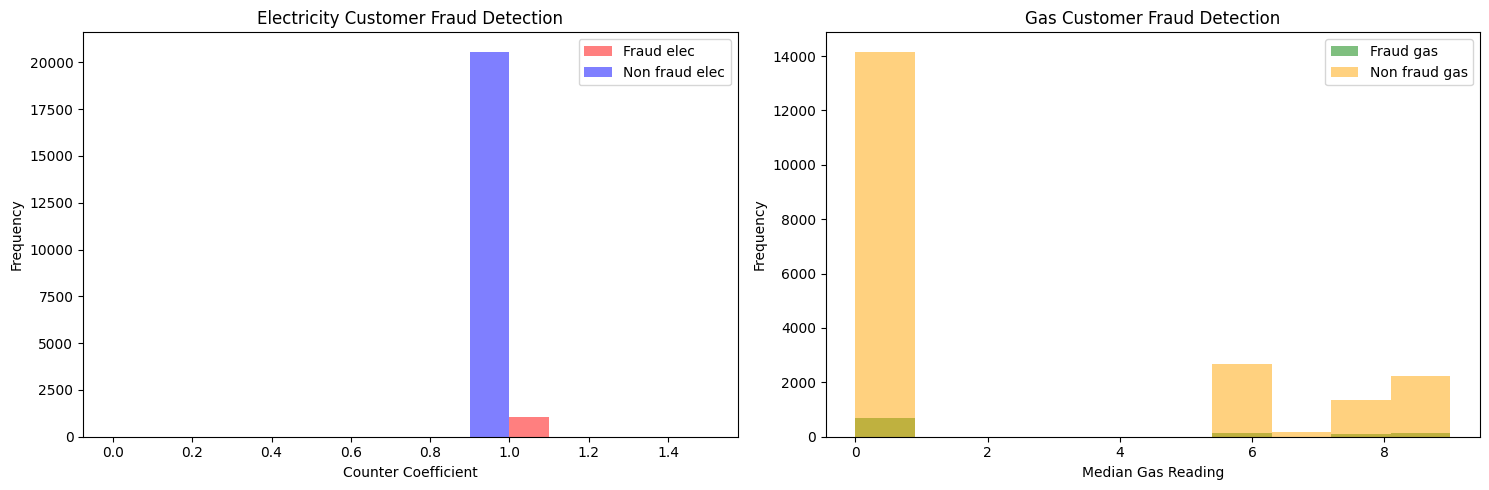

In [ ]:
# optional
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(fraud_plot['counter_coeff_have1'], color='red', alpha=0.5, label='Fraud elec')
plt.hist(nonfraud_plot['counter_coeff_have1'], color='blue', alpha=0.5, label='Non fraud elec')
plt.title('Electricity Customer Fraud Detection')
plt.xlabel('Counter Coefficient')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(fraud_plot['median_reading_gas'], color='green', alpha=0.5, label='Fraud gas')
plt.hist(nonfraud_plot['median_reading_gas'], color='orange', alpha=0.5, label='Non fraud gas')
plt.title('Gas Customer Fraud Detection')
plt.xlabel('Median Gas Reading')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

This shows that the mean and standard deviation of consommation sum for each user is less stable for fraud clients. We suspect that this might have been due to their invoices having varying consommation sum (consommation sum = sum of all consommation level of that invoice).

[optional]

Text(0.5, 1.0, 'non fraud gas')

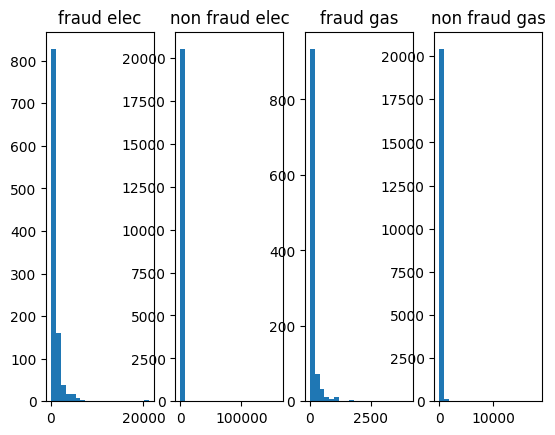

In [ ]:
# optional
plt.subplot(1, 4, 1)
plt.hist(fraud_plot['sd_consommation_sum_elec'], bins = 20)
plt.title('fraud elec')
plt.subplot(1, 4, 2)
plt.hist(nonfraud_plot['sd_consommation_sum_elec'], bins = 20)
plt.title('non fraud elec')

plt.subplot(1, 4, 3)
plt.hist(fraud_plot['sd_consommation_sum_gas'], bins = 20)
plt.title('fraud gas')
plt.subplot(1, 4, 4)
plt.hist(nonfraud_plot['sd_consommation_sum_gas'], bins = 20)
plt.title('non fraud gas')

[optional]

Text(0.5, 1.0, 'non fraud gas')

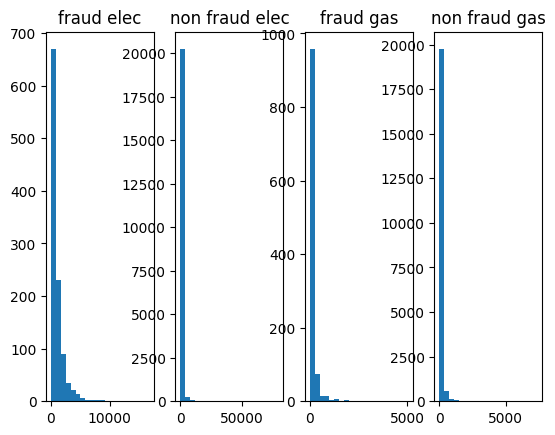

In [22]:
# optional
plt.subplot(1, 4, 1)
plt.hist(fraud_plot['mean_consommation_sum_elec'], bins = 20)
plt.title('fraud elec')
plt.subplot(1, 4, 2)
plt.hist(nonfraud_plot['mean_consommation_sum_elec'], bins = 20)
plt.title('non fraud elec')

plt.subplot(1, 4, 3)
plt.hist(fraud_plot['mean_consommation_sum_gas'], bins = 20)
plt.title('fraud gas')
plt.subplot(1, 4, 4)
plt.hist(nonfraud_plot['mean_consommation_sum_gas'], bins = 20)
plt.title('non fraud gas')

From the graph below, we can see that the number of elec invoice per client is more right-skewed for non-fraud clients.

[optional]

Text(0.5, 1.0, 'non fraud gas')

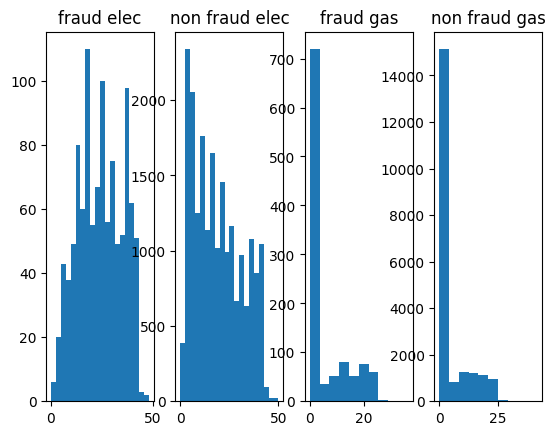

In [ ]:
# optional
plt.subplot(1, 4, 1)
plt.hist(fraud_plot['num_elec_invoice'], bins = 20)
plt.title('fraud elec')
plt.subplot(1, 4, 2)
plt.hist(nonfraud_plot['num_elec_invoice'], bins = 20)
plt.title('non fraud elec')

plt.subplot(1, 4, 3)
plt.hist(fraud_plot['num_gas_invoice'])
plt.title('fraud gas')
plt.subplot(1, 4, 4)
plt.hist(nonfraud_plot['num_gas_invoice'])
plt.title('non fraud gas')

The parameter mean_oldVSnew of each invoice is the difference between the new and old indices. Afterwards, for each client, we find the mean of their invoice difference.


[optional]

Text(0.5, 1.0, 'non fraud gas')

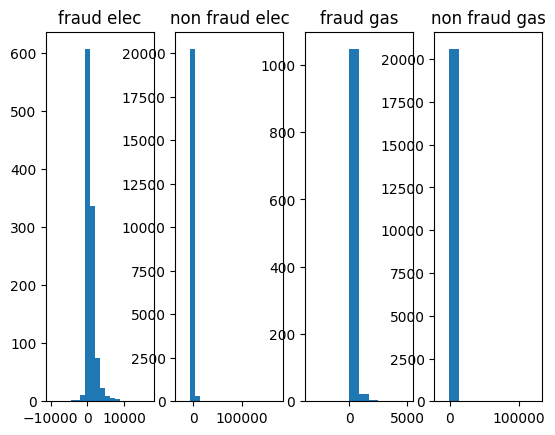

In [ ]:
# optional
plt.subplot(1, 4, 1)
plt.hist(fraud_plot['mean_oldVSnew_elec'], bins = 20)
plt.title('fraud elec')
plt.subplot(1, 4, 2)
plt.hist(nonfraud_plot['mean_oldVSnew_elec'], bins = 20)
plt.title('non fraud elec')

plt.subplot(1, 4, 3)
plt.hist(fraud_plot['mean_oldVSnew_gas'])
plt.title('fraud gas')
plt.subplot(1, 4, 4)
plt.hist(nonfraud_plot['mean_oldVSnew_gas'])
plt.title('non fraud gas')

# Undersampling & splitting dataset


We applied the above defined function invoice_to_client to our dataframes.

The resulting dataframe will be used to train our models.

In [ ]:
from sklearn.model_selection import train_test_split
# Assuming 'target' and 'id' are columns to be excluded
X = client_data.copy()

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Perform undersampling
non_frauds = len(X_train[X_train['target'] == 1])
non_fraud_indices = X_train[X_train.target == 0].index

random_indices = np.random.choice(non_fraud_indices, non_frauds, replace=False) # random
fraud_indices = X_train[X_train.target == 1].index

under_sample_indices = np.concatenate([fraud_indices,random_indices])
X_train = X_train.loc[under_sample_indices]
invoice_under_train = invoice_data[invoice_data['id'].isin(X_train['id'])]


X_train = invoice_to_client(invoice_under_train, X_train)
X_test = invoice_to_client(invoice_data, X_test)

X_train

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-7ba0d95e1616>:96: RuntimeWarning: invalid value encountered in divide
  d = d / np.sum(d)
<ipython-input-4-7ba0d95e1616>:106: RuntimeWarning: invalid value encountered in divide
  d = d / np.sum(d)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered

,region,date,dis,catg,target,range_year_client_elec,range_year_client_gas,mean_year_client_elec,sd_year_client_elec,mean_year_client_gas,...,consommation_lv4,mean_consommation_sum_elec,sd_consommation_sum_elec,mean_consommation_sum_gas,sd_consommation_sum_gas,mean_oldVSnew_gas,mean_oldVSnew_elec,num_gas_invoice,num_elec_invoice,range_month_num
id,,,,,,,,,,,,,,,,,,,,,
train_Client_102707,303,2010,62,11,1,3.0,0.0,8,0.707107,0,...,0.000000,536.375000,329.740025,0.000000,0.000000,0.000000,536.375000,0,8,6
train_Client_105088,107,1997,69,11,1,13.0,4.0,17,0.655555,8,...,0.000000,793.823529,586.664874,92.125000,78.624801,92.125000,793.823529,8,17,26
train_Client_117440,302,1981,62,11,1,14.0,3.0,39,0.611010,10,...,0.020408,695.487179,411.114363,94.800000,55.607194,94.800000,695.487179,10,39,6
train_Client_102350,311,1987,63,11,1,14.0,6.0,32,0.805536,14,...,0.000000,514.968750,231.415277,79.714286,33.739397,79.714286,514.968750,14,32,6
train_Client_107300,302,1988,62,11,1,14.0,0.0,36,0.711805,0,...,0.000000,379.611111,464.118237,0.000000,0.000000,0.000000,379.611111,0,36,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_117675,104,2000,69,11,0,13.0,11.0,14,0.496904,16,...,0.000000,1449.857143,1143.265302,131.937500,125.835443,112.250000,1449.857143,16,14,6
train_Client_118790,101,1995,60,11,0,1.0,0.0,3,0.500000,0,...,0.000000,709.000000,201.565539,0.000000,0.000000,0.000000,709.000000,0,3,0
train_Client_111392,101,2017,60,11,0,2.0,0.0,5,0.471405,0,...,0.000000,1116.400000,533.606447,0.000000,0.000000,0.000000,1116.400000,0,5,4


We further perform some data standardisation and normalisation.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

columns_to_encode = ['region', 'dis', 'catg']
one_hot_encoded = pd.get_dummies(X_train[columns_to_encode])
one_hot_encoded1 = pd.get_dummies(X_test[columns_to_encode])

# Concatenate the one-hot encoded columns with the original DataFrame
X_train = pd.concat([X_train.drop(columns=['region','dis','catg']), one_hot_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=['region','dis','catg']), one_hot_encoded1], axis=1)

# Select columns to standardize
selected_columns = [ 'range_year_client_elec',
       'range_year_client_gas', 'mean_year_client_elec', 'sd_year_client_elec',
       'mean_year_client_gas', 'sd_year_client_gas' , 'prop_counter_statue_elec_0',
       'prop_counter_statue_elec_1', 'prop_counter_statue_elec_2',
       'prop_counter_statue_elec_3', 'prop_counter_statue_elec_4',
       'prop_counter_statue_elec_5', 'prop_counter_statue_gas_0',
       'prop_counter_statue_gas_1', 'prop_counter_statue_gas_2',
       'prop_counter_statue_gas_3', 'prop_counter_statue_gas_4',
       'prop_counter_statue_gas_5', 'median_reading_elec',
       'range_reading_elec', 'median_reading_gas', 'range_reading_gas',
       'mean_consommation_sum_elec', 'sd_consommation_sum_elec',
       'mean_consommation_sum_gas', 'sd_consommation_sum_gas',
       'mean_oldVSnew_gas', 'mean_oldVSnew_elec', 'range_month_num']

# Initialize StandardScaler
scaler = StandardScaler().set_output(transform="pandas")

# Fit and transform the selected columns
X_train[selected_columns] = scaler.fit_transform(X_train[selected_columns])
X_test[selected_columns] = scaler.fit_transform(X_test[selected_columns])


# Assuming 'selected_cols' is a list of column names to normalize
selected_cols = ['date','unique_counter_num_elec',
       'unique_counter_num_gas','unique_tarif_type_elec', 'unique_tarif_type_gas',
       'unique_counter_code_elec', 'unique_counter_code_gas','num_gas_invoice',
       'num_elec_invoice']

# Initialize MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas")

# Fit and transform the selected columns
X_train[selected_cols] = scaler.fit_transform(X_train[selected_cols])
X_test[selected_cols] = scaler.fit_transform(X_test[selected_cols])

We extract the column 'target' from the dataframe to create our label vector.

In [ ]:
y_train=X_train['target']
y_test=X_test['target']

X_train=X_train.drop(columns='target')
X_test=X_test.drop(columns='target')

# **Machine learning Models**



We run the following models without fine-tuning our parameters to obtain the raw accuracy rates.

For each of our model, we plot a confusion matrix along with the classification report for easy reference.

**Logistic Regression**

Accuracy: 0.7711844839528977
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4095
           1       0.15      0.68      0.25       236

    accuracy                           0.77      4331
   macro avg       0.56      0.73      0.56      4331
weighted avg       0.93      0.77      0.83      4331



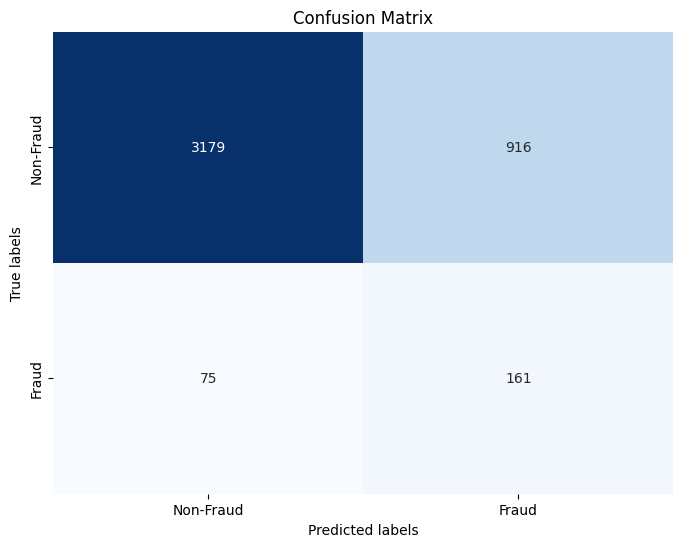

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_lr = TP / (TP + FN)

# True Negative Rate
TNR_lr = TN / (TN + FP)

**Random Forest**

Random Forest Accuracy: 0.7547910413299469
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      4095
           1       0.15      0.72      0.24       236

    accuracy                           0.75      4331
   macro avg       0.56      0.74      0.55      4331
weighted avg       0.93      0.75      0.82      4331



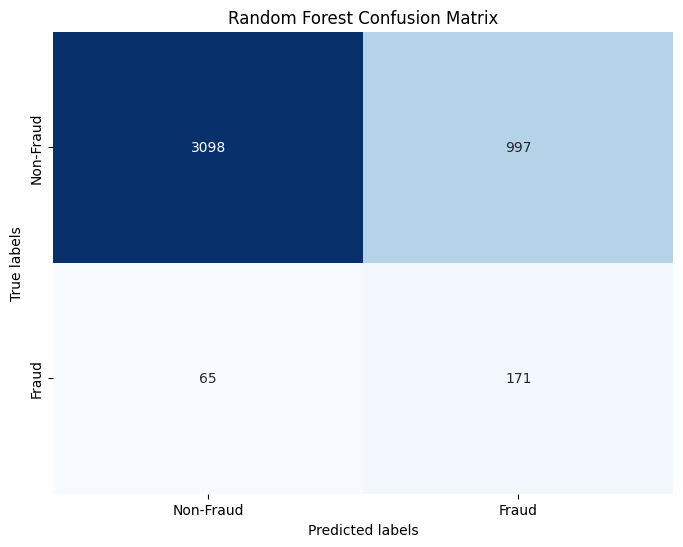

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
rf_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", accuracy_rf)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_rf = TP / (TP + FN)

# True Negative Rate
TNR_rf = TN / (TN + FP)

**Naive Bayes**

Naive Bayes Accuracy: 0.9244978065111983
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4095
           1       0.14      0.07      0.09       236

    accuracy                           0.92      4331
   macro avg       0.54      0.52      0.53      4331
weighted avg       0.90      0.92      0.91      4331



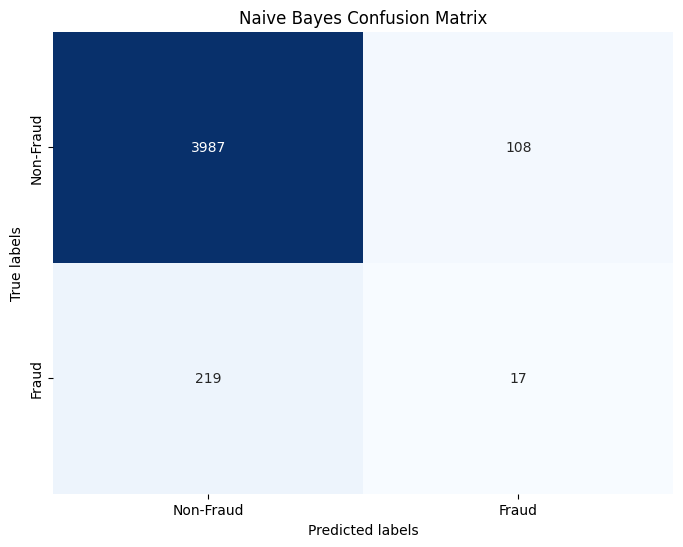

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB() # no need for random_state=42 because this model doesn't involve randomness during training

# Train the model
nb_classifier.fit(X_train, y_train)

# Predictions on the test set
nb_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", accuracy_nb)

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_nb = TP / (TP + FN)

# True Negative Rate
TNR_nb = TN / (TN + FP)

**Multilayer Peceptron**

Multilayer Perceptron Accuracy: 0.47979681366889865
Multilayer Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.46      0.63      4095
           1       0.08      0.83      0.15       236

    accuracy                           0.48      4331
   macro avg       0.53      0.65      0.39      4331
weighted avg       0.93      0.48      0.60      4331



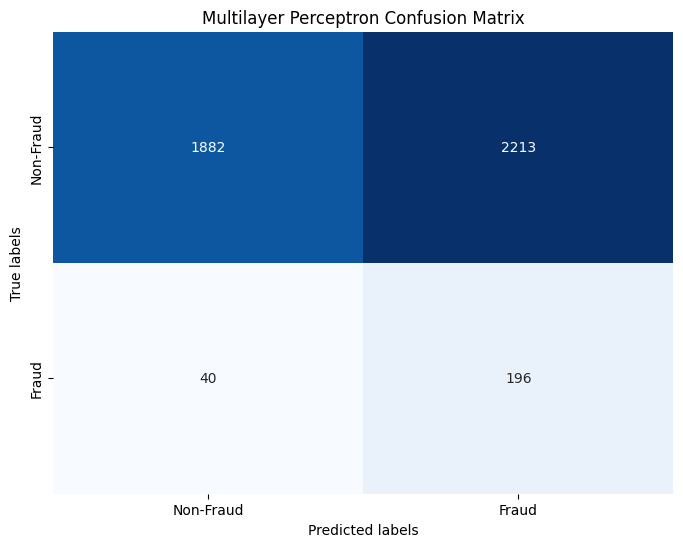

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Train the model
mlp_classifier.fit(X_train, y_train)

# Predictions on the test set
mlp_pred = mlp_classifier.predict(X_test)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test, mlp_pred)
print("Multilayer Perceptron Accuracy:", accuracy_mlp)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, mlp_pred))

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, mlp_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Multilayer Perceptron Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_mlp = TP / (TP + FN)

# True Negative Rate
TNR_mlp = TN / (TN + FP)

# **Principal Component Analysis (PCA)**


Firstly, we derive the PCA array which determine the explained variance ratio of the selected principal components.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Initialize PCA
pca = PCA()

# Fit PCA
pca.fit(X_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
selected_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

pca.explained_variance_ratio_

array([9.95461867e-01, 1.22738892e-03, 1.01701685e-03, 5.98381530e-04,
       2.39020838e-04, 2.22430327e-04, 2.07278450e-04, 1.49727619e-04,
       1.15492688e-04, 9.66909450e-05])

In [ ]:
# option
X_train_pca # to take a look


array([[ 9.84546764e+01, -3.79637415e-01,  8.66005949e-01, ...,
        -5.22957824e-01, -2.51173615e-02, -3.08411991e-01],
       [-9.76366193e+01, -9.86050771e-01, -4.53192411e+00, ...,
        -1.09107148e-01,  2.07021525e-01, -1.26295464e-02],
       [ 9.74336889e+01, -3.53255219e-01, -1.00233788e+00, ...,
         6.82822950e-01, -9.41932506e-02,  2.76009090e-01],
       ...,
       [-1.03495273e+02, -1.66844674e+00,  5.53270797e+00, ...,
        -1.98919288e+00, -2.64078992e-01,  1.71917232e-02],
       [-1.00611029e+02, -1.17818736e+00, -2.52312550e+00, ...,
         6.88524476e-01, -3.35267379e-01, -2.47720060e-01],
       [ 1.66448405e+02,  2.93902585e-02, -3.04161605e-02, ...,
        -1.56490120e+00,  1.48669011e-01, -1.47522780e-01]])

Then, we train the models with the obtained PCA array.

**Logistic Regression**

Accuracy: 0.5047333179404294
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.65      4095
           1       0.08      0.80      0.15       236

    accuracy                           0.50      4331
   macro avg       0.53      0.64      0.40      4331
weighted avg       0.93      0.50      0.62      4331



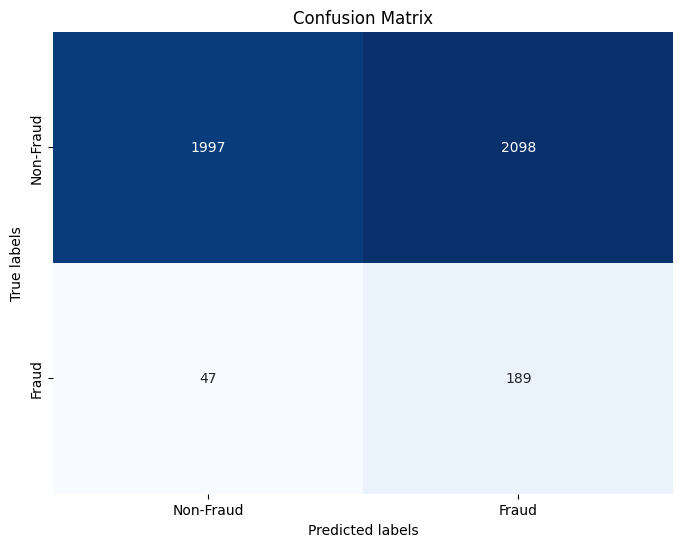

In [ ]:
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train_pca, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test_pca)

# Calculate accuracy
accuracy_lr_pca = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr_pca)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_lr_pca = TP / (TP + FN)

# True Negative Rate
TNR_lr_pca = TN / (TN + FP)

Random Forest Accuracy: 0.489725236665897
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.47      0.64      4095
           1       0.08      0.81      0.15       236

    accuracy                           0.49      4331
   macro avg       0.53      0.64      0.39      4331
weighted avg       0.93      0.49      0.61      4331



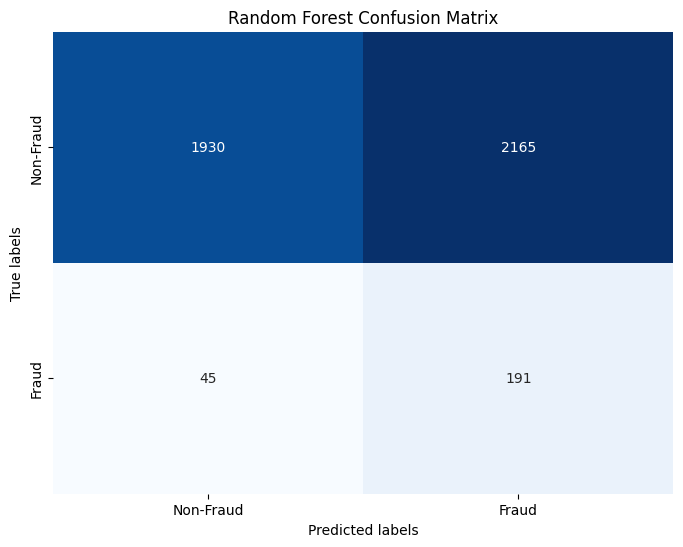

In [ ]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_pca, y_train)

# Predictions on the test set
rf_pred = rf_classifier.predict(X_test_pca)

# Calculate accuracy
accuracy_rf_pca = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", accuracy_rf_pca)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_rf_pca = TP / (TP + FN)

# True Negative Rate
TNR_rf_pca = TN / (TN + FP)

Naive Bayes Accuracy: 0.6111752482105749
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      4095
           1       0.09      0.65      0.15       236

    accuracy                           0.61      4331
   macro avg       0.53      0.63      0.45      4331
weighted avg       0.92      0.61      0.72      4331



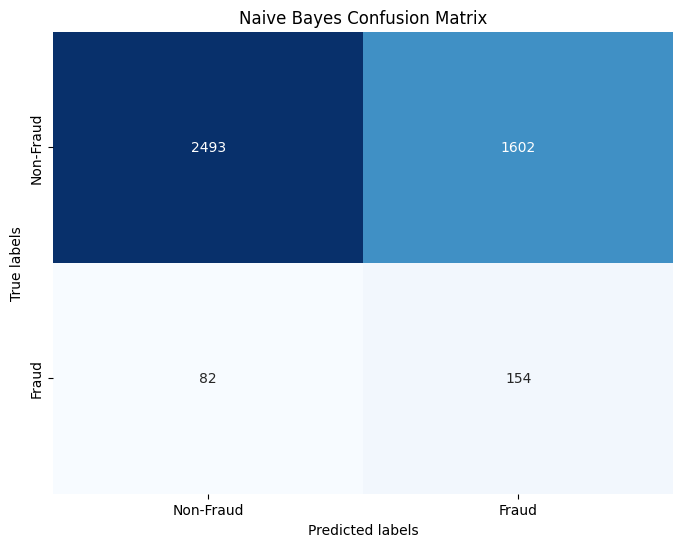

In [ ]:
# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the model
nb_classifier.fit(X_train_pca, y_train)

# Predictions on the test set
nb_pred = nb_classifier.predict(X_test_pca)

# Calculate accuracy
accuracy_nb_pca = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", accuracy_nb_pca)

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_nb_pca = TP / (TP + FN)

# True Negative Rate
TNR_nb_pca = TN / (TN + FP)

Multilayer Perceptron Accuracy: 0.49226506580466406
Multilayer Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.47      0.64      4095
           1       0.08      0.82      0.15       236

    accuracy                           0.49      4331
   macro avg       0.53      0.65      0.39      4331
weighted avg       0.93      0.49      0.61      4331



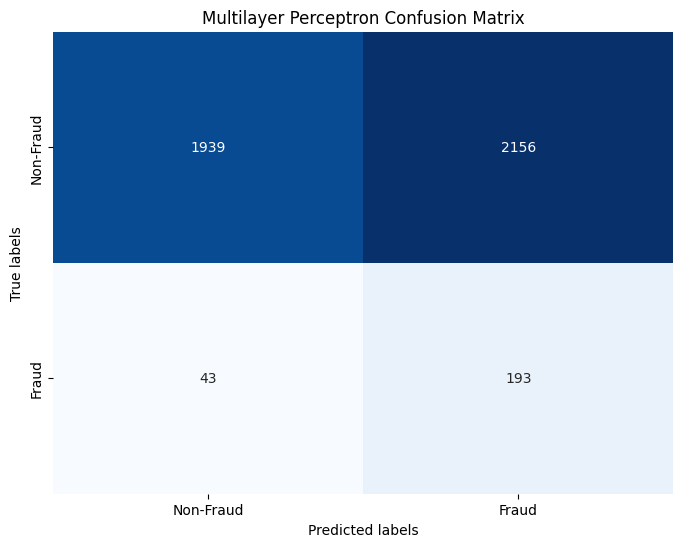

In [ ]:
# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42)

# Train the model
mlp_classifier.fit(X_train_pca, y_train)

# Predictions on the test set
mlp_pred = mlp_classifier.predict(X_test_pca)

# Calculate accuracy
accuracy_mlp_pca = accuracy_score(y_test, mlp_pred)
print("Multilayer Perceptron Accuracy:", accuracy_mlp_pca)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, mlp_pred))

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, mlp_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Multilayer Perceptron Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_mlp_pca = TP / (TP + FN)

# True Negative Rate
TNR_mlp_pca = TN / (TN + FP)



# **Stepwise Regression**

We first obtain the subset of features that best explain the variation in the target.

In [ ]:
import statsmodels.api as sm

def stepwise_selection(X, y):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        pval = pd.Series(index=remaining_features)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [feature]])).fit()
            pval[feature] = model.pvalues[feature]
        min_p_value = pval.min()
        if min_p_value < 0.05:
            best_features.append(pval.idxmin())
        else:
            break
    return best_features

selected_features = stepwise_selection(X_train, y_train)
print("Selected features:", selected_features)


# Subset the feature matrix with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Selected features: ['counter_coeff_have1', 'unique_counter_num_elec', 'unique_counter_code_elec', 'range_year_client_elec', 'dis', 'sd_consommation_sum_elec', 'date', 'prop_counter_statue_elec_5', 'consommation_lv3', 'range_reading_gas', 'consommation_lv4', 'range_year_client_gas', 'mean_oldVSnew_elec', 'prop_counter_statue_elec_0', 'median_reading_gas', 'mean_year_client_elec', 'num_elec_invoice', 'unique_counter_num_gas', 'consommation_lv2', 'range_month_num']


In [ ]:
X_train_selected # [optional] to take a look at the new training data

,counter_coeff_have1,unique_counter_num_elec,dis,range_year_client_elec,consommation_lv4,unique_counter_code_elec,unique_tarif_type_elec,date,prop_counter_statue_elec_5,prop_counter_statue_elec_0,sd_consommation_sum_gas,consommation_lv3,prop_counter_statue_elec_3,region,mean_year_client_elec,num_elec_invoice
id,,,,,,,,,,,,,,,,
train_Client_102707,1,0.25,62,-1.200648,0.000000,0.333333,0.25,0.785714,-0.227737,-0.828082,-0.304769,0.0,-0.034524,303,-1.146035,0.16
train_Client_105088,1,0.50,69,0.989697,0.000000,0.333333,0.25,0.476190,-0.227737,0.339656,0.027735,0.0,-0.034524,107,-0.389286,0.34
train_Client_117440,1,0.25,62,1.208731,0.020408,0.333333,0.25,0.095238,-0.227737,0.339656,-0.069606,0.0,-0.034524,302,1.460547,0.78
train_Client_102350,1,0.50,63,1.208731,0.000000,0.333333,0.25,0.238095,-0.227737,0.339656,-0.162085,0.0,-0.034524,311,0.871964,0.64
train_Client_107300,1,0.50,62,1.208731,0.000000,0.333333,0.25,0.261905,-0.227737,0.339656,-0.304769,0.0,-0.034524,302,1.208297,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_126910,1,0.25,60,1.208731,0.000000,0.333333,0.25,0.500000,-0.227737,0.339656,-0.304769,0.0,-0.034524,101,1.460547,0.78
train_Client_124647,1,0.25,62,0.113559,0.000000,0.333333,0.25,0.785714,-0.227737,-0.049590,-0.304769,0.0,-0.034524,301,0.199297,0.48
train_Client_119589,1,0.25,69,0.332593,0.535714,0.333333,0.25,0.761905,-0.227737,0.339656,-0.304769,0.0,-0.034524,107,0.535631,0.56


**Logistic Regression**

Accuracy: 0.7762641422304317
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4095
           1       0.15      0.69      0.25       236

    accuracy                           0.78      4331
   macro avg       0.57      0.74      0.56      4331
weighted avg       0.93      0.78      0.83      4331



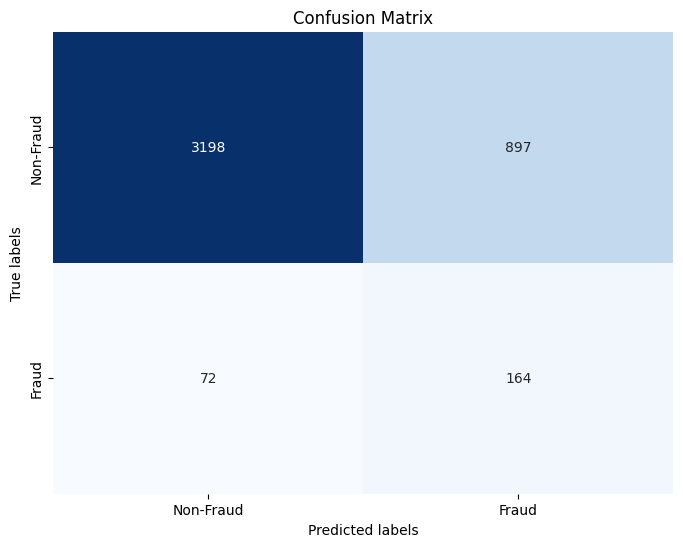

In [ ]:
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
log_reg.fit(X_train_selected, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test_selected)

# Calculate accuracy
accuracy_lr_sr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr_sr)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_lr_sr = TP / (TP + FN)

# True Negative Rate
TNR_lr_sr = TN / (TN + FP)

**Random Forest**

Random Forest Accuracy: 0.7529438928653891
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      4095
           1       0.14      0.72      0.24       236

    accuracy                           0.75      4331
   macro avg       0.56      0.74      0.55      4331
weighted avg       0.93      0.75      0.82      4331



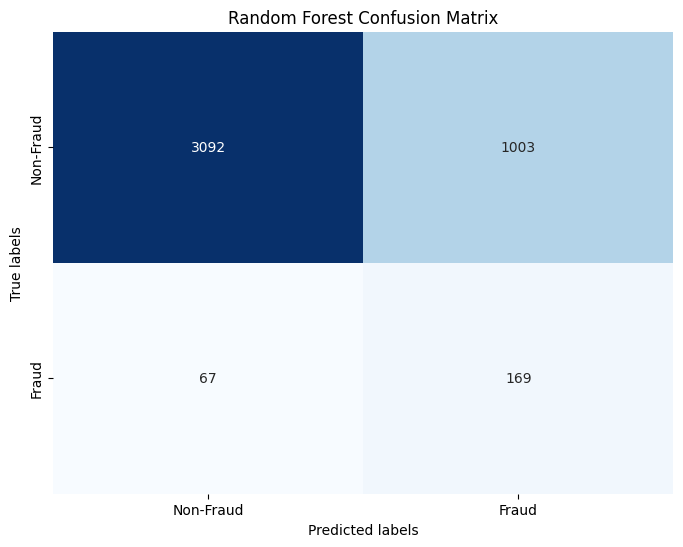

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_selected, y_train)

# Predictions on the test set
rf_pred = rf_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy_rf_sr = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", accuracy_rf_sr)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_rf_sr = TP / (TP + FN)

# True Negative Rate
TNR_rf_sr = TN / (TN + FP)

**Naive Bayes**

Naive Bayes Accuracy: 0.8633110136227199
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      4095
           1       0.16      0.36      0.22       236

    accuracy                           0.86      4331
   macro avg       0.56      0.63      0.57      4331
weighted avg       0.92      0.86      0.89      4331



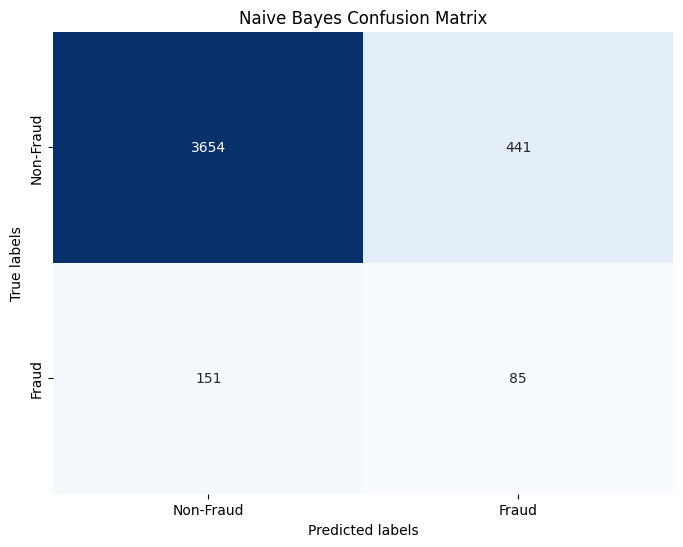

In [ ]:
# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the model
nb_classifier.fit(X_train_selected, y_train)

# Predictions on the test set
nb_pred = nb_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy_nb_sr = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", accuracy_nb_sr)

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_nb_sr = TP / (TP + FN)

# True Negative Rate
TNR_nb_sr = TN / (TN + FP)

**Multilayer Perceptron**

Multilayer Perceptron Accuracy: 0.8559224197644886
Multilayer Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      4095
           1       0.19      0.51      0.28       236

    accuracy                           0.86      4331
   macro avg       0.58      0.69      0.60      4331
weighted avg       0.93      0.86      0.89      4331



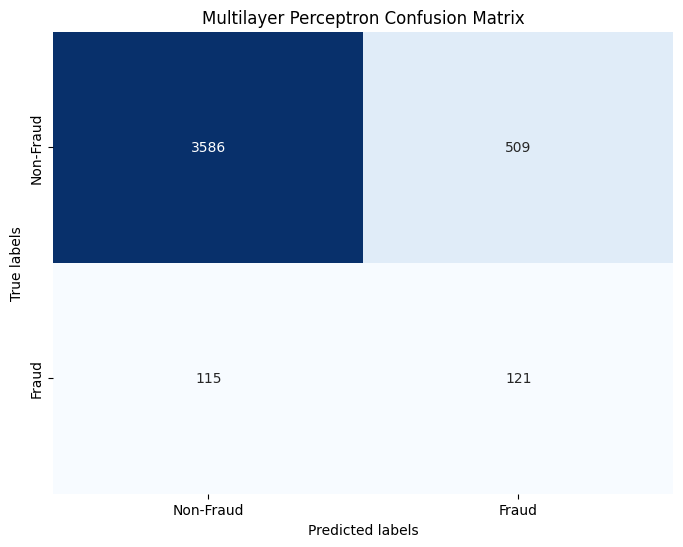

In [ ]:
# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Train the model
mlp_classifier.fit(X_train_selected, y_train)

# Predictions on the test set
mlp_pred = mlp_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy_mlp_sr = accuracy_score(y_test, mlp_pred)
print("Multilayer Perceptron Accuracy:", accuracy_mlp_sr)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, mlp_pred))

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, mlp_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Multilayer Perceptron Confusion Matrix')
plt.show()

# True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# True Positive Rate
TPR_mlp_sr = TP / (TP + FN)

# True Negative Rate
TNR_mlp_sr = TN / (TN + FP)

# **Hyperparameter Importance Analysis**

For each of the model, we use HIA to find the importance rate for each feature. Then, we determine a threshold and select the features which has importance rate greater that the threshold for training.

Thereafter, a graph of accuracy against threshold is plotted to determine the optimal threshold.

**Logistic Regression**

In [ ]:
from sklearn.inspection import permutation_importance

log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test)

# Perform permutation importance analysis
result = permutation_importance(log_reg, X_train, y_train, n_repeats=10, random_state=42)

# Extract feature importances
importance = result.importances_mean

# Compute the maximum, minimum, mean, and median of the importance values
max_importance = np.max(importance)
min_importance = np.min(importance)
mean_importance = np.mean(importance)
median_importance = np.median(importance)

# Print the results
print("Maximum importance:", max_importance)
print("Minimum importance:", min_importance)
print("Mean importance:", mean_importance)
print("Median importance:", median_importance)

Maximum importance: 0.13059523809523813
Minimum importance: -0.0020238095238095167
Mean importance: 0.012036474164133748
Median importance: 0.0027976190476190375


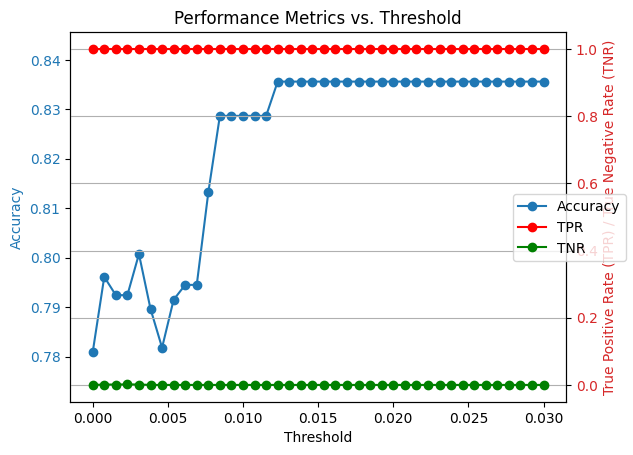

Maximum Accuracy Rate: 0.8356037866543523
Corresponding TPR: 1.0
Corresponding TNR: 0.0


In [ ]:
import matplotlib.pyplot as plt

# Define a list of thresholds to test
thresholds = np.linspace(0, 0.03, 40)

# Initialize lists to store accuracy, true positive rate, and true negative rate values
accuracies = []
true_positive_rates = []
true_negative_rates = []

# Iterate over each threshold
for threshold in thresholds:
    # Select features based on the threshold
    selected = [i for i, imp in enumerate(importance) if imp > threshold]
    selected_features = np.array(selected)

    # Filter the training and testing data to include only the selected features
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train a new classifier using only the selected features
    model_selected = LogisticRegression(max_iter=10000, random_state=42)
    model_selected.fit(X_train_selected, y_train)

    # Predict probabilities and convert to binary predictions using the threshold
    y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate accuracy, true positive rate, and true negative rate
    accuracy_selected = model_selected.score(X_test_selected, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    # Append the metrics to the respective lists
    accuracies.append(accuracy_selected)
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Plot the graph
fig, ax1 = plt.subplots()

# Plot accuracy on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(thresholds, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(accuracies)-0.01, max(accuracies)+0.01])

# Create secondary y-axis for TPR and TNR
ax2 = ax1.twinx()

# Plot TPR on secondary y-axis
color = 'tab:red'
ax2.set_ylabel('True Positive Rate (TPR) / True Negative Rate (TNR)', color=color)
ax2.plot(thresholds, true_positive_rates, marker='o', color='red', label='TPR')
ax2.plot(thresholds, true_negative_rates, marker='o', color='green', label='TNR')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
fig.legend(loc='center right')

# Title and grid
plt.title('Performance Metrics vs. Threshold')
plt.grid(True)

plt.show()

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Extract the maximum accuracy rate
accuracy_lr_hia = accuracies[max_accuracy_index]

# Extract the corresponding True Positive Rate (TPR) and True Negative Rate (TNR)
TPR_lr_hia = true_positive_rates[max_accuracy_index]
TNR_lr_hia = true_negative_rates[max_accuracy_index]

print("Maximum Accuracy Rate:", accuracy_lr_hia)
print("Corresponding TPR:", TPR_lr_hia)
print("Corresponding TNR:", TNR_lr_hia)


Maximum Accuracy Rate: 0.8356037866543523
Corresponding TPR: 1.0
Corresponding TNR: 0.0


**Random Forest**

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Perform permutation importance analysis
result = permutation_importance(rf_classifier, X_train, y_train, n_repeats=10, random_state=42)

# Extract feature importances
importance = result.importances_mean

# Compute the maximum, minimum, mean, and median of the importance values
max_importance = np.max(importance)
min_importance = np.min(importance)
mean_importance = np.mean(importance)
median_importance = np.median(importance)

# Print the results
print("Maximum importance:", max_importance)
print("Minimum importance:", min_importance)
print("Mean importance:", mean_importance)
print("Median importance:", median_importance)

Maximum importance: 0.17964285714285716
Minimum importance: 0.0
Mean importance: 0.007280901722391075
Median importance: 0.0


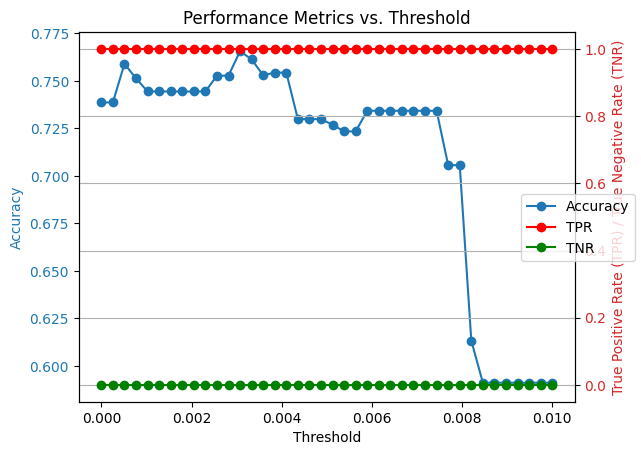

Maximum Accuracy Rate: 0.7656430385592242
Corresponding TPR: 1.0
Corresponding TNR: 0.0


In [ ]:
# Define a list of thresholds to test
thresholds = np.linspace(0, 0.01, 40)

# Initialize lists to store accuracy values
accuracies = []
true_positive_rates = []
true_negative_rates = []


# Iterate over each threshold
for threshold in thresholds:
    # Select features based on the threshold
    selected = [i for i, imp in enumerate(importance) if imp > threshold]
    selected_features = np.array(selected)

    # Filter the training and testing data to include only the selected features
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train a new classifier using only the selected features
    model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    model_selected.fit(X_train_selected, y_train)

    # Calculate accuracy, true positive rate, and true negative rate
    accuracy_selected = model_selected.score(X_test_selected, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    # Append the metrics to the respective lists
    accuracies.append(accuracy_selected)
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Plot the graph
fig, ax1 = plt.subplots()

# Plot accuracy on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(thresholds, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(accuracies)-0.01, max(accuracies)+0.01])

# Create secondary y-axis for TPR and TNR
ax2 = ax1.twinx()

# Plot TPR on secondary y-axis
color = 'tab:red'
ax2.set_ylabel('True Positive Rate (TPR) / True Negative Rate (TNR)', color=color)
ax2.plot(thresholds, true_positive_rates, marker='o', color='red', label='TPR')
ax2.plot(thresholds, true_negative_rates, marker='o', color='green', label='TNR')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
fig.legend(loc='center right')

# Title and grid
plt.title('Performance Metrics vs. Threshold')
plt.grid(True)

plt.show()

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Extract the maximum accuracy rate
accuracy_rf_hia = accuracies[max_accuracy_index]

# Extract the corresponding True Positive Rate (TPR) and True Negative Rate (TNR)
TPR_rf_hia = true_positive_rates[max_accuracy_index]
TNR_rf_hia = true_negative_rates[max_accuracy_index]

print("Maximum Accuracy Rate:", accuracy_rf_hia)
print("Corresponding TPR:", TPR_rf_hia)
print("Corresponding TNR:", TNR_rf_hia)

**Naive Bayes**

In [ ]:
nb_classifier = GaussianNB()

# Train the model
nb_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Perform permutation importance analysis
result = permutation_importance(nb_classifier, X_train, y_train, n_repeats=10, random_state=42)

# Extract feature importances
importance = result.importances_mean

# Compute the maximum, minimum, mean, and median of the importance values
max_importance = np.max(importance)
min_importance = np.min(importance)
mean_importance = np.mean(importance)
median_importance = np.median(importance)

# Print the results
print("Maximum importance:", max_importance)
print("Minimum importance:", min_importance)
print("Mean importance:", mean_importance)
print("Median importance:", median_importance)

Maximum importance: 0.03880952380952378
Minimum importance: -0.012142857142857132
Mean importance: 0.0017312563323201595
Median importance: 0.0005357142857142838


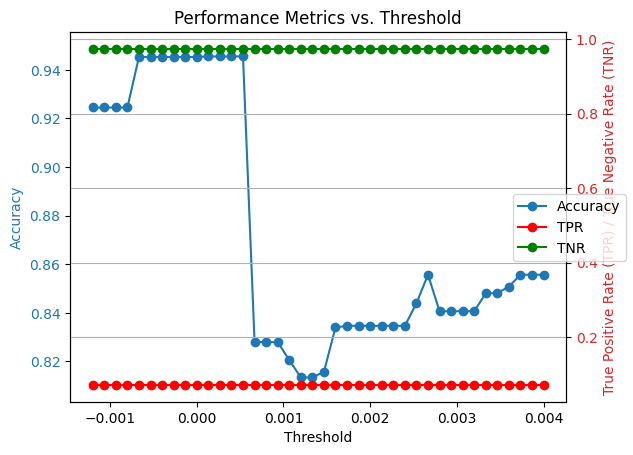

Maximum Accuracy Rate: 0.9455091202955438
Corresponding TPR: 0.07203389830508475
Corresponding TNR: 0.9736263736263736


In [ ]:
# Define a list of thresholds to test
thresholds = np.linspace(-0.0012, 0.004, 40)

# Initialize lists to store accuracy values
accuracies = []
true_positive_rates = []
true_negative_rates = []

# Iterate over each threshold
for threshold in thresholds:
    # Select features based on the threshold
    selected = [i for i, imp in enumerate(importance) if imp > threshold]
    selected_features = np.array(selected)

    if len(selected_features) > 0:
        # Filter the training and testing data to include only the selected features
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]

        # Train a new classifier using only the selected features
        model_selected = GaussianNB()
        model_selected.fit(X_train_selected, y_train)

        # Calculate accuracy, true positive rate, and true negative rate
        accuracy_selected = model_selected.score(X_test_selected, y_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        # Append the metrics to the respective lists
        accuracies.append(accuracy_selected)
        true_positive_rates.append(tpr)
        true_negative_rates.append(tnr)
    else:
        # If no features are selected, append NaN
        accuracies.append(np.nan)
        true_positive_rates.append(np.nan)
        true_negative_rates.append(np.nan)

# Plot the graph
fig, ax1 = plt.subplots()

# Plot accuracy on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(thresholds, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(accuracies)-0.01, max(accuracies)+0.01])

# Create secondary y-axis for TPR and TNR
ax2 = ax1.twinx()

# Plot TPR on secondary y-axis
color = 'tab:red'
ax2.set_ylabel('True Positive Rate (TPR) / True Negative Rate (TNR)', color=color)
ax2.plot(thresholds, true_positive_rates, marker='o', color='red', label='TPR')
ax2.plot(thresholds, true_negative_rates, marker='o', color='green', label='TNR')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
fig.legend(loc='center right')

# Title and grid
plt.title('Performance Metrics vs. Threshold')
plt.grid(True)

plt.show()

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Extract the maximum accuracy rate
accuracy_nb_hia = accuracies[max_accuracy_index]

# Extract the corresponding True Positive Rate (TPR) and True Negative Rate (TNR)
TPR_nb_hia = true_positive_rates[max_accuracy_index]
TNR_nb_hia = true_negative_rates[max_accuracy_index]

print("Maximum Accuracy Rate:", accuracy_nb_hia)
print("Corresponding TPR:", TPR_nb_hia)
print("Corresponding TNR:", TNR_nb_hia)

**Perceptron**

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Train the model
mlp_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = mlp_classifier.predict(X_test)

# Perform permutation importance analysis
result = permutation_importance(mlp_classifier, X_train, y_train, n_repeats=10, random_state=42)

# Extract feature importances
importance = result.importances_mean

# Compute the maximum, minimum, mean, and median of the importance values
max_importance = np.max(importance)
min_importance = np.min(importance)
mean_importance = np.mean(importance)
median_importance = np.median(importance)

# Print the results
print("Maximum importance:", max_importance)
print("Minimum importance:", min_importance)
print("Mean importance:", mean_importance)
print("Median importance:", median_importance)

Maximum importance: 0.039702380952380954
Minimum importance: -0.0024404761904761817
Mean importance: 0.004616261398176287
Median importance: 0.0017857142857142794


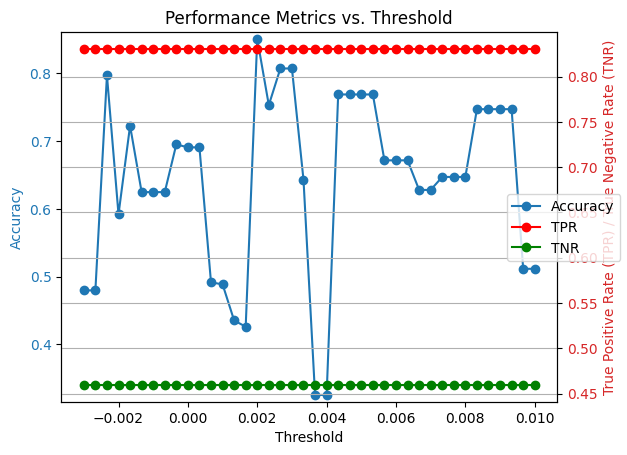

Maximum Accuracy Rate: 0.8508427614869545
Corresponding TPR: 0.8305084745762712
Corresponding TNR: 0.45958485958485956


In [ ]:
# Define a list of thresholds to test
thresholds = np.linspace(-0.003, 0.01, 40)

# Initialize lists to store accuracy values
accuracies = []
true_positive_rates = []
true_negative_rates = []

# Iterate over each threshold
for threshold in thresholds:
    # Select features based on the threshold
    selected = [i for i, imp in enumerate(importance) if imp > threshold]
    selected_features = np.array(selected)

    # Filter the training and testing data to include only the selected features
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Train a new classifier using only the selected features
    model_selected = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    model_selected.fit(X_train_selected, y_train)

    # Calculate accuracy, true positive rate, and true negative rate
    accuracy_selected = model_selected.score(X_test_selected, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    # Append the metrics to the respective lists
    accuracies.append(accuracy_selected)
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Plot the graph
fig, ax1 = plt.subplots()

# Plot accuracy on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(thresholds, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(accuracies)-0.01, max(accuracies)+0.01])

# Create secondary y-axis for TPR and TNR
ax2 = ax1.twinx()

# Plot TPR on secondary y-axis
color = 'tab:red'
ax2.set_ylabel('True Positive Rate (TPR) / True Negative Rate (TNR)', color=color)
ax2.plot(thresholds, true_positive_rates, marker='o', color='red', label='TPR')
ax2.plot(thresholds, true_negative_rates, marker='o', color='green', label='TNR')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
fig.legend(loc='center right')

# Title and grid
plt.title('Performance Metrics vs. Threshold')
plt.grid(True)

plt.show()

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Extract the maximum accuracy rate
accuracy_mlp_hia = accuracies[max_accuracy_index]

# Extract the corresponding True Positive Rate (TPR) and True Negative Rate (TNR)
TPR_mlp_hia = true_positive_rates[max_accuracy_index]
TNR_mlp_hia = true_negative_rates[max_accuracy_index]

print("Maximum Accuracy Rate:", accuracy_mlp_hia)
print("Corresponding TPR:", TPR_mlp_hia)
print("Corresponding TNR:", TNR_mlp_hia)

# **Overall Comparison**

**Logistic Regression**

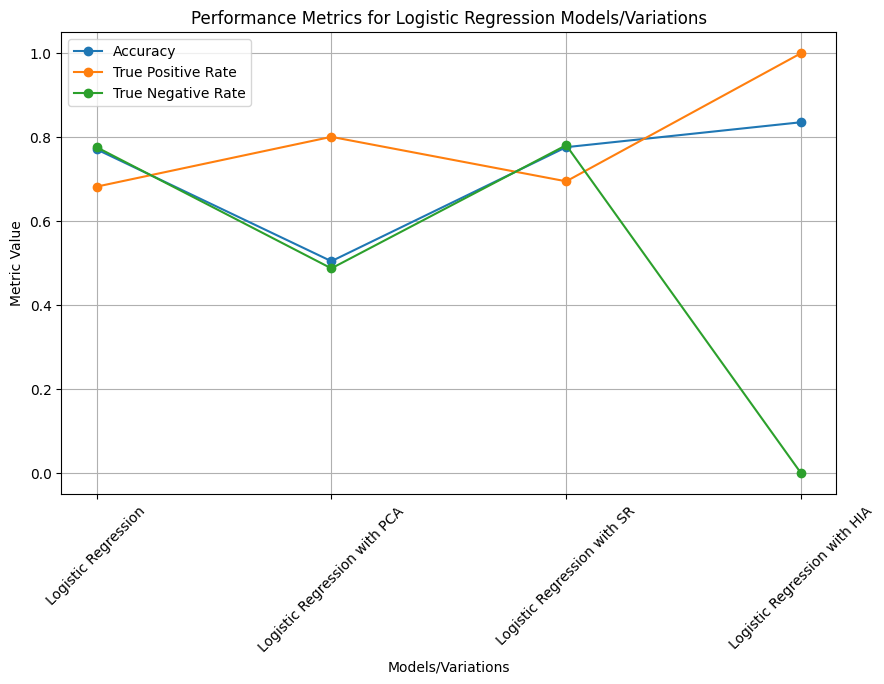

In [ ]:
import matplotlib.pyplot as plt

# Lists containing accuracy, TPR, and TNR values for different logistic regression models/variations
accuracies_lr = [accuracy_lr, accuracy_lr_pca, accuracy_lr_sr, accuracy_lr_hia]
TPRs_lr = [TPR_lr, TPR_lr_pca, TPR_lr_sr, TPR_lr_hia]
TNRs_lr = [TNR_lr, TNR_lr_pca, TNR_lr_sr, TNR_lr_hia]

# Labels for the different models/variations
labels = ['Logistic Regression', 'Logistic Regression with PCA',
          'Logistic Regression with SR', 'Logistic Regression with HIA']

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(labels, accuracies_lr, marker='o', label='Accuracy')

# TPR plot
plt.plot(labels, TPRs_lr, marker='o', label='True Positive Rate')

# TNR plot
plt.plot(labels, TNRs_lr, marker='o', label='True Negative Rate')

# Add labels and title
plt.xlabel('Models/Variations')
plt.ylabel('Metric Value')
plt.title('Performance Metrics for Logistic Regression Models/Variations')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show plot
plt.show()



**Random Forest**

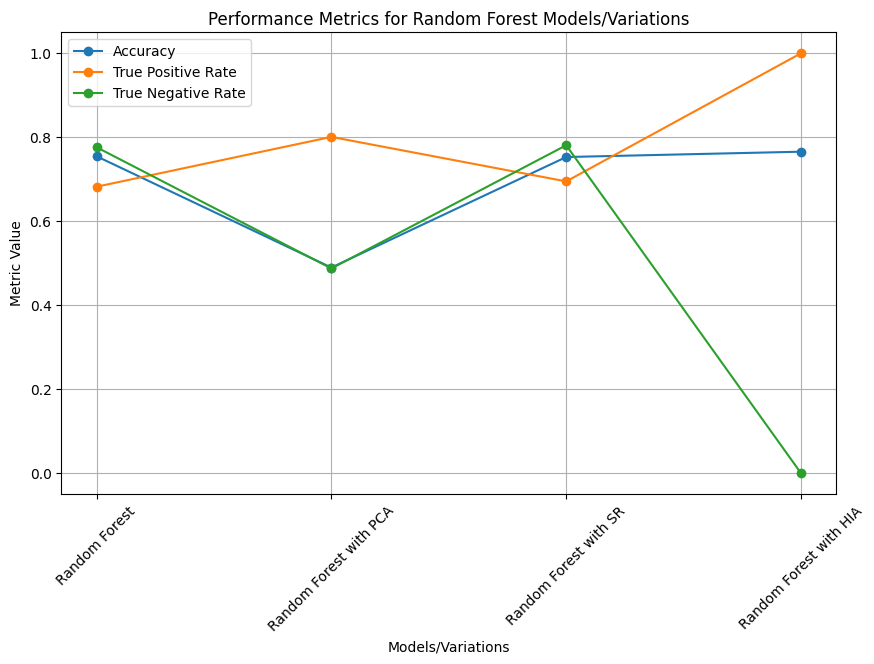

In [ ]:
import matplotlib.pyplot as plt

# Lists containing accuracy, TPR, and TNR values for different random forest models/variations
accuracies_rf = [accuracy_rf, accuracy_rf_pca, accuracy_rf_sr, accuracy_rf_hia]
TPRs_rf = [TPR_rf, TPR_rf_pca, TPR_rf_sr, TPR_rf_hia]
TNRs_rf = [TNR_rf, TNR_rf_pca, TNR_rf_sr, TNR_rf_hia]

# Labels for the different models/variations
labels = ['Random Forest', 'Random Forest with PCA',
          'Random Forest with SR', 'Random Forest with HIA']

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(labels, accuracies_rf, marker='o', label='Accuracy')

# TPR plot
plt.plot(labels, TPRs_rf, marker='o', label='True Positive Rate')

# TNR plot
plt.plot(labels, TNRs_rf, marker='o', label='True Negative Rate')

# Add labels and title
plt.xlabel('Models/Variations')
plt.ylabel('Metric Value')
plt.title('Performance Metrics for Random Forest Models/Variations')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show plot
plt.show()


**Naive Bayes**

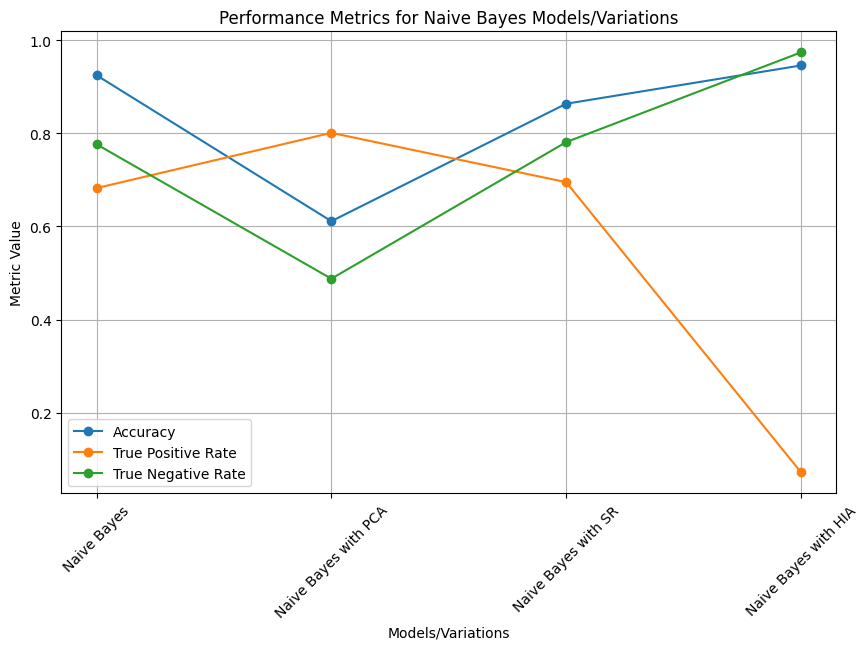

In [ ]:
import matplotlib.pyplot as plt

# Lists containing accuracy, TPR, and TNR values for different Naive Bayes models/variations
accuracies_nb = [accuracy_nb, accuracy_nb_pca, accuracy_nb_sr, accuracy_nb_hia]
TPRs_nb = [TPR_nb, TPR_nb_pca, TPR_nb_sr, TPR_nb_hia]
TNRs_nb = [TNR_nb, TNR_nb_pca, TNR_nb_sr, TNR_nb_hia]

# Labels for the different models/variations
labels = ['Naive Bayes', 'Naive Bayes with PCA',
          'Naive Bayes with SR', 'Naive Bayes with HIA']

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(labels, accuracies_nb, marker='o', label='Accuracy')

# TPR plot
plt.plot(labels, TPRs_nb, marker='o', label='True Positive Rate')

# TNR plot
plt.plot(labels, TNRs_nb, marker='o', label='True Negative Rate')

# Add labels and title
plt.xlabel('Models/Variations')
plt.ylabel('Metric Value')
plt.title('Performance Metrics for Naive Bayes Models/Variations')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show plot
plt.show()


**Multilayer Perceptron**

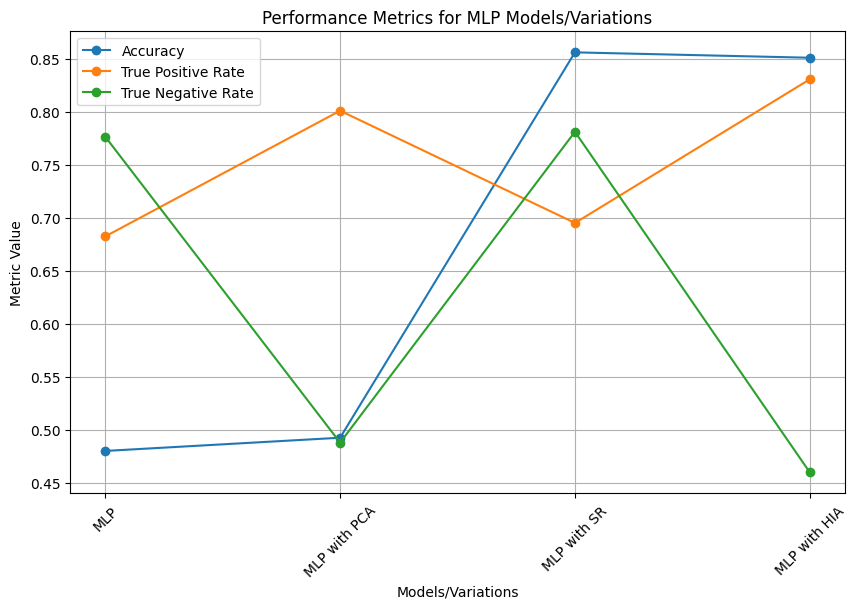

In [ ]:
import matplotlib.pyplot as plt

# Lists containing accuracy, TPR, and TNR values for different MLP models/variations
accuracies_mlp = [accuracy_mlp, accuracy_mlp_pca, accuracy_mlp_sr, accuracy_mlp_hia]
TPRs_mlp = [TPR_mlp, TPR_mlp_pca, TPR_mlp_sr, TPR_mlp_hia]
TNRs_mlp = [TNR_mlp, TNR_mlp_pca, TNR_mlp_sr, TNR_mlp_hia]

# Labels for the different models/variations
labels = ['MLP', 'MLP with PCA',
          'MLP with SR', 'MLP with HIA']

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(labels, accuracies_mlp, marker='o', label='Accuracy')

# TPR plot
plt.plot(labels, TPRs_mlp, marker='o', label='True Positive Rate')

# TNR plot
plt.plot(labels, TNRs_mlp, marker='o', label='True Negative Rate')

# Add labels and title
plt.xlabel('Models/Variations')
plt.ylabel('Metric Value')
plt.title('Performance Metrics for MLP Models/Variations')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show plot
plt.show()
